In [16]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from google.colab import drive
#pede acesso ao drive
drive.mount('/content/drive')
import os
#acessa a pasta vacinacaoMS para salvar os dados
os.chdir('/content/drive/MyDrive/vacinacaoms')

Mounted at /content/drive


# Salvando Bases No Google Drive(caso não tenha)

Base de dados de vacinação MS (atualmente 1.6 gb)

In [ ]:
#https://dados.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8
!wget https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-10-06/uf%3DMS/part-00000-fc441216-95a5-479b-9662-4587a3a08f7c.c000.csv

--2021-10-07 19:14:04--  https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/PNI/vacina/uf/2021-10-06/uf%3DMS/part-00000-fc441216-95a5-479b-9662-4587a3a08f7c.c000.csv
Resolving s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)... 52.95.163.112
Connecting to s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)|52.95.163.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2012504410 (1.9G) [text/csv]
Saving to: ‘part-00000-fc441216-95a5-479b-9662-4587a3a08f7c.c000.csv’

part-00000-fc441216 100%[===================>]   1.87G  20.6MB/s    in 96s     

2021-10-07 19:15:41 (19.9 MB/s) - ‘part-00000-fc441216-95a5-479b-9662-4587a3a08f7c.c000.csv’ saved [2012504410/2012504410]



Base dados de casos do Brasil (Atualmente 200 mb)

In [ ]:
!wget https://data.brasil.io/dataset/covid19/caso.csv.gz

--2021-10-07 19:11:31--  https://data.brasil.io/dataset/covid19/caso.csv.gz
Resolving data.brasil.io (data.brasil.io)... 172.67.71.45, 104.26.9.175, 104.26.8.175, ...
Connecting to data.brasil.io (data.brasil.io)|172.67.71.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28880222 (28M) [application/gzip]
Saving to: ‘caso.csv.gz’

caso.csv.gz         100%[===================>]  27.54M  11.3MB/s    in 2.4s    

2021-10-07 19:11:33 (11.3 MB/s) - ‘caso.csv.gz’ saved [28880222/28880222]



# Abrindo arquivos

Salvando a base de dados no google drive

In [115]:
caso = pd.read_csv("caso.csv.gz",compression='gzip',sep=',')

In [116]:
dadoMS = pd.read_csv("part-00000-fc441216-95a5-479b-9662-4587a3a08f7c.c000.csv",sep=';')

In [117]:
dadoMS.head(3)

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,paciente_endereco_nmpais,paciente_endereco_uf,paciente_endereco_cep,paciente_nacionalidade_enumnacionalidade,estabelecimento_valor,estabelecimento_razaosocial,estalecimento_nofantasia,estabelecimento_municipio_codigo,estabelecimento_municipio_nome,estabelecimento_uf,vacina_grupoatendimento_codigo,vacina_grupoatendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem
0,8a739609-4b13-4d26-8873-292837af2bbb-i0b0,6d0c9e2feeaf2cea17fc8282e2b20ec2acc140fb3e3099...,43.0,1977-07-15,F,5.0,INDIGENA,500795.0,10.0,TACURU,BRASIL,MS,79975.0,B,6889158,DISTRITO ESPECIAL INDIGENA DE MATO GROSSO DO SUL,POLO BASE DE TACURU,500795,TACURU,MS,701,Povos indígenas em terras indígenas,7.0,Povos Indígenas,202010021,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-23,2ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-02-24T20:22:41.000Z,16341
1,29183bfb-8e21-477c-8544-178aa9268c83-i0b0,4612e9247e04f4e6afadf50d85b9ff9ebfb31630ab3304...,66.0,1954-11-19,F,3.0,PARDA,500330.0,10.0,COXIM,BRASIL,MS,79400.0,B,2752549,PREFEITURA MUNICIPAL DE COXIM,POLICLINICA LOURDES FONTOURA,500330,COXIM,MS,202,Pessoas de 65 a 69 anos,2.0,Faixa Etária,210210,FUNDACAO BUTANTAN,Organization/61189445000156,2021-05-10,2ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-05-12T18:36:41.000Z,16341
2,64af9fc9-e67f-4810-991c-f28a70c7ed18-i0b0,5bc1ca0d79b23ce12735583fd26ded2b13833bc054c0e1...,31.0,1990-06-16,M,1.0,BRANCA,500370.0,10.0,DOURADOS,BRASIL,MS,79822.0,B,9181261,CAIXA DE ASSISTENCIA DOS SERVIDORES DO ESTADO ...,CENTRO MEDICO E DE DIAGNOSTICO AVANCADO,500270,CAMPO GRANDE,MS,926,Outros,9.0,Trabalhadores de Saúde,216VCD176Z,University of Oxford/AstraZeneca,NaN,2021-07-06,2ª Dose,85,Vacina Covid-19 - Covishield,Vacina Campo Grande,2021-07-07T06:06:29.000Z,18241


In [118]:
caso.head(3)

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2021-10-06,AP,NaN,state,122961,1986,562,True,845731.0,861773.0,16.0,14268.37462,0.0162
1,2021-10-05,AP,NaN,state,122937,1986,561,False,845731.0,861773.0,16.0,14265.58966,0.0162
2,2021-10-04,AP,NaN,state,122897,1984,560,False,845731.0,861773.0,16.0,14260.94807,0.0161


# Editando tabelas

In [119]:
from unicodedata import normalize
#extraindo colunas
casos=caso[caso['state']=='MS']
casos=casos[["date","state","city","confirmed","deaths","estimated_population"]]
#convertendo os caracters dos nomes das cidade para poderem ser comparados
casos.loc[:,"date" ]=pd.to_datetime(casos["date"]);
casos['city'] =  casos['city'].str.upper();
casos['city']=casos['city'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8');
#ordenando
casos= casos.set_index('date').sort_index()
casos= casos.reset_index()
#removendo na
casos=casos.fillna(-1)
casos=casos[casos['city']!=-1]

In [120]:
#extraindo colunas
vacina=dadoMS[["vacina_dataaplicacao","vacina_descricao_dose","vacina_fabricante_nome","estabelecimento_uf","estabelecimento_municipio_nome","paciente_idade"]]
vacina.loc[:,"vacina_dataaplicacao" ]=pd.to_datetime(vacina["vacina_dataaplicacao"]);
#ordenando tabela por dia
vacina=vacina.set_index('vacina_dataaplicacao').sort_index()
vacina=vacina.reset_index();
#display(vacina.dtypes)
vacina

,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome,estabelecimento_uf,estabelecimento_municipio_nome,paciente_idade
0,2021-01-17,2ª Dose,FUNDACAO BUTANTAN,MS,IVINHEMA,38.0
1,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,INOCENCIA,80.0
2,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,JAPORA,25.0
3,2021-01-17,1ª Dose,FUNDACAO OSWALDO CRUZ,MS,RIBAS DO RIO PARDO,23.0
4,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,INOCENCIA,65.0
...,...,...,...,...,...,...
3697482,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,PORTO MURTINHO,47.0
3697483,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,TRES LAGOAS,57.0
3697484,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,CASSILANDIA,48.0
3697485,2021-10-04,2ª Dose,FUNDACAO OSWALDO CRUZ,MS,NOVA ANDRADINA,41.0


# Contando dose de vacina por cidade.

In [121]:
#procura se é a primeira dose ou a segunda de cada um dos pacientes e marca com 1 em uma nova tabela
vacina["primeiradoseref"]=  [1 if '1' in x  else 0 for x in vacina['vacina_descricao_dose']]
vacina["segundadoseref"]=  [1 if '2'in x  else 0 for x in vacina['vacina_descricao_dose']]
display(vacina)
#pega a nova tabela e faz uma soma cumulativa baseada nas doses aplicadas de cada cidade.
vacina["primeira_dose"]=vacina.groupby('estabelecimento_municipio_nome')['primeiradoseref'].cumsum()
vacina["segunda_dose"]=vacina.groupby('estabelecimento_municipio_nome')['segundadoseref'].cumsum()
vacina=vacina[["vacina_dataaplicacao","estabelecimento_municipio_nome","estabelecimento_uf","primeira_dose","segunda_dose","paciente_idade"]]
display(vacina)

,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome,estabelecimento_uf,estabelecimento_municipio_nome,paciente_idade,primeiradoseref,segundadoseref
0,2021-01-17,2ª Dose,FUNDACAO BUTANTAN,MS,IVINHEMA,38.0,0,1
1,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,INOCENCIA,80.0,1,0
2,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,JAPORA,25.0,1,0
3,2021-01-17,1ª Dose,FUNDACAO OSWALDO CRUZ,MS,RIBAS DO RIO PARDO,23.0,1,0
4,2021-01-17,1ª Dose,FUNDACAO BUTANTAN,MS,INOCENCIA,65.0,1,0
...,...,...,...,...,...,...,...,...
3697482,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,PORTO MURTINHO,47.0,0,1
3697483,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,TRES LAGOAS,57.0,0,1
3697484,2021-10-04,2ª Dose,MINISTERIO DA SAUDE,MS,CASSILANDIA,48.0,0,1
3697485,2021-10-04,2ª Dose,FUNDACAO OSWALDO CRUZ,MS,NOVA ANDRADINA,41.0,0,1


,vacina_dataaplicacao,estabelecimento_municipio_nome,estabelecimento_uf,primeira_dose,segunda_dose,paciente_idade
0,2021-01-17,IVINHEMA,MS,0,1,38.0
1,2021-01-17,INOCENCIA,MS,1,0,80.0
2,2021-01-17,JAPORA,MS,1,0,25.0
3,2021-01-17,RIBAS DO RIO PARDO,MS,1,0,23.0
4,2021-01-17,INOCENCIA,MS,2,0,65.0
...,...,...,...,...,...,...
3697482,2021-10-04,PORTO MURTINHO,MS,7822,5749,47.0
3697483,2021-10-04,TRES LAGOAS,MS,93960,65576,57.0
3697484,2021-10-04,CASSILANDIA,MS,17133,13435,48.0
3697485,2021-10-04,NOVA ANDRADINA,MS,36293,28024,41.0


# Montando a tabela fato "Vacinação" do Datawarehouse

In [122]:
#renomeando colunas
vacina.columns = ['date', 'city', 'estabelecimento_uf', 'primeira_dose', 'segunda_dose','vacina_grupoatendimento_nome']
#removendo cidades duplicadas para fazer o merge
vacina= vacina.drop_duplicates(subset=["date","city"], keep="last")


In [123]:
#juntando tabelas
merged=vacina.merge(casos,on=['date','city'])
merged.columns=['dia','cidade','estado','primeira_dose','segunda_dose','idade','estado2','casos','mortes','populacao']
tabeladw=merged[['dia','cidade','estado','primeira_dose','segunda_dose','idade','casos','mortes','populacao']]
tabeladw['mortes_por_1000_habitantes']=tabeladw['mortes']*1000/tabeladw['populacao']
tabeladw

,dia,cidade,estado,primeira_dose,segunda_dose,idade,casos,mortes,populacao,mortes_por_1000_habitantes
0,2021-01-17,JAPORA,MS,1,0,25.0,37,3,9243.0,0.324570
1,2021-01-17,RIBAS DO RIO PARDO,MS,1,0,23.0,512,5,24966.0,0.200272
2,2021-01-17,IVINHEMA,MS,0,2,20.0,857,16,23232.0,0.688705
3,2021-01-17,AMAMBAI,MS,1,0,40.0,1490,26,39826.0,0.652840
4,2021-01-17,DOURADOS,MS,1,0,44.0,16773,197,225495.0,0.873634
...,...,...,...,...,...,...,...,...,...,...
12091,2021-08-22,AGUA CLARA,MS,10575,2576,12.0,2916,66,15776.0,4.183570
12092,2021-08-22,CAMPO GRANDE,MS,646087,342647,18.0,132845,3902,906092.0,4.306406
12093,2021-08-22,BELA VISTA,MS,11474,7154,12.0,1075,31,24735.0,1.253285
12094,2021-08-22,AQUIDAUANA,MS,31031,20093,16.0,5630,159,48029.0,3.310500


# Análise

In [124]:
cidade = "CAMPO GRANDE"#@param {type:"string"}
tabela=tabeladw.loc[tabeladw["cidade"]==cidade]
tabela=tabela.set_index("dia").sort_index();
tabela=tabela.reset_index()
tabela

,dia,cidade,estado,primeira_dose,segunda_dose,idade,casos,mortes,populacao,mortes_por_1000_habitantes
0,2021-01-19,CAMPO GRANDE,MS,1883,7,25.0,66748,1228,906092.0,1.355271
1,2021-01-20,CAMPO GRANDE,MS,4111,9,47.0,67097,1231,906092.0,1.358582
2,2021-01-21,CAMPO GRANDE,MS,6424,15,66.0,67300,1242,906092.0,1.370722
3,2021-01-22,CAMPO GRANDE,MS,8152,25,31.0,67568,1249,906092.0,1.378447
4,2021-01-23,CAMPO GRANDE,MS,8153,25,40.0,67786,1257,906092.0,1.387276
...,...,...,...,...,...,...,...,...,...,...
204,2021-08-18,CAMPO GRANDE,MS,629412,334278,14.0,131589,3879,906092.0,4.281022
205,2021-08-19,CAMPO GRANDE,MS,634622,337167,57.0,131954,3885,906092.0,4.287644
206,2021-08-20,CAMPO GRANDE,MS,634880,338890,52.0,132277,3891,906092.0,4.294266
207,2021-08-21,CAMPO GRANDE,MS,645332,341443,53.0,132580,3898,906092.0,4.301991


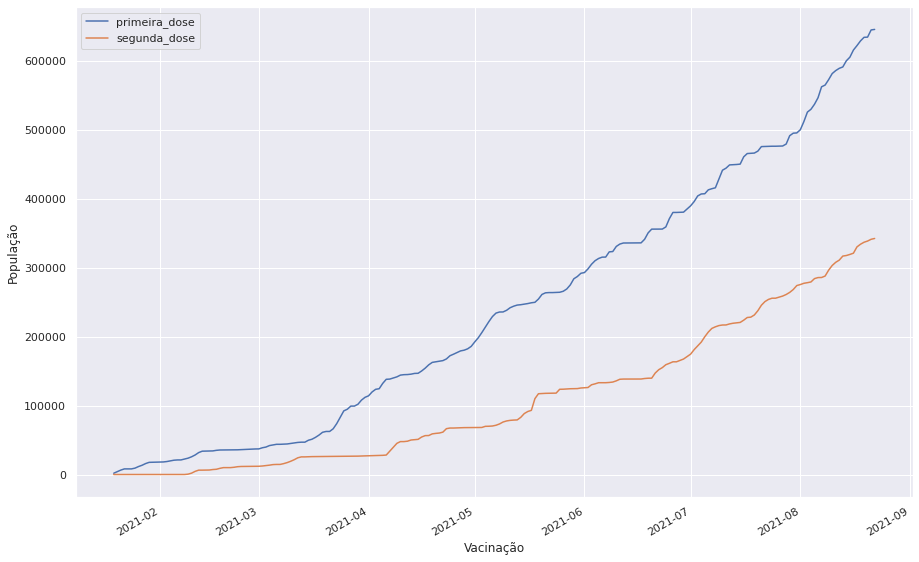

In [125]:
sns.set(rc={'figure.figsize':(15,10)})
ax = plt.gca()

tabela.plot(kind='line',x='dia',y=['primeira_dose'],style=['-'], ax=ax)
tabela.plot(kind='line',x='dia',y=['segunda_dose'],style=['-'], ax=ax)
plt.ylabel('População')
plt.xlabel('Vacinação')
plt.show()

# Gráfico de vacinação

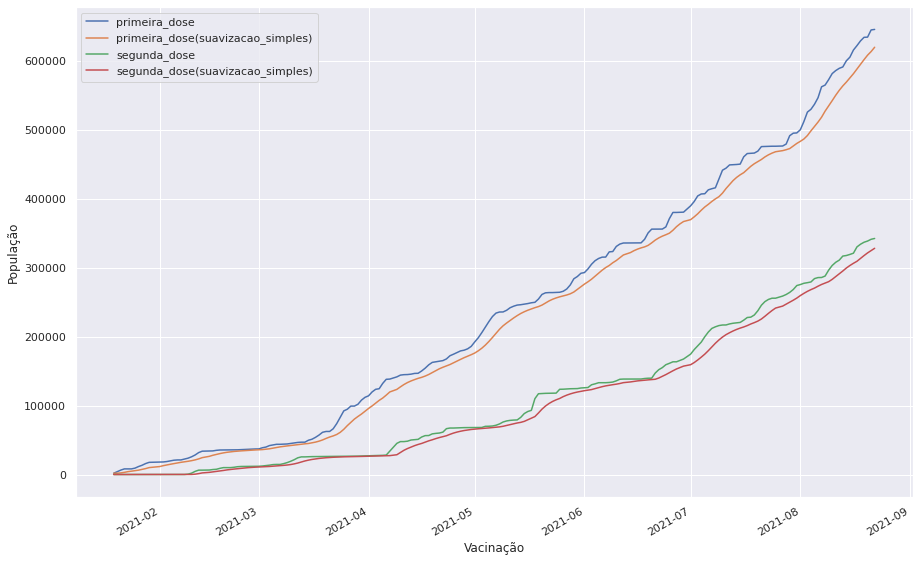

In [126]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

sns.set(rc={'figure.figsize':(15,10)})
ax = plt.gca()


fit1 = SimpleExpSmoothing(tabela["primeira_dose"]).fit(
    smoothing_level=0.2, optimized=False
)
tabela["primeira_dose(suavizacao_simples)"]=pd.DataFrame(fit1.fittedvalues)

fit2 = SimpleExpSmoothing(tabela["segunda_dose"]).fit(
    smoothing_level=0.2, optimized=False
)
tabela["segunda_dose(suavizacao_simples)"]=pd.DataFrame(fit2.fittedvalues)


tabela.plot(kind='line',x='dia',y=['primeira_dose'],style=['-'], ax=ax)
tabela.plot(kind='line',x='dia',y=['primeira_dose(suavizacao_simples)'],style=['-'], ax=ax)
tabela.plot(kind='line',x='dia',y=['segunda_dose'],style=['-'], ax=ax)
tabela.plot(kind='line',x='dia',y=['segunda_dose(suavizacao_simples)'],style=['-'], ax=ax)
plt.ylabel('População')
plt.xlabel('Vacinação')

plt.show()

# Gráfico de predição de imunização completa

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


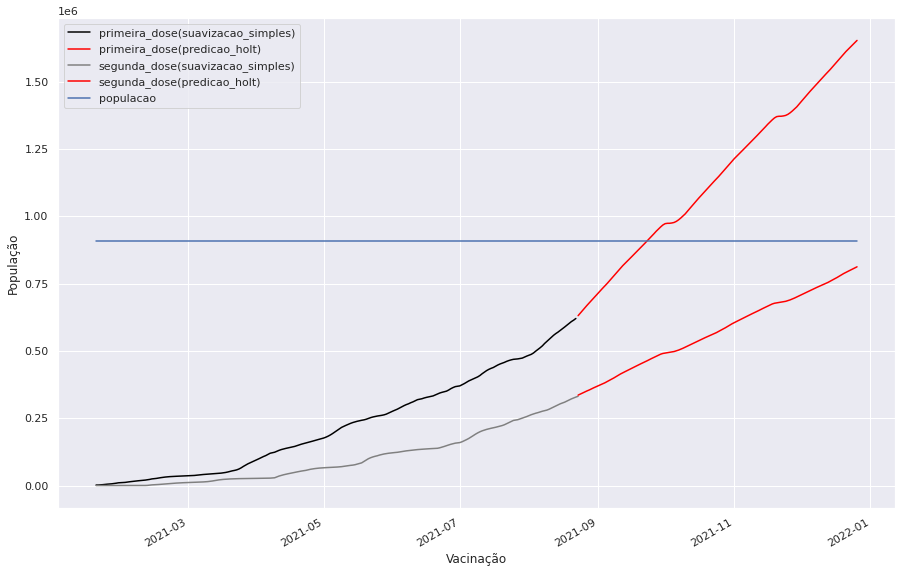

In [127]:
import copy
sns.set(rc={'figure.figsize':(15,10)})
ax = plt.gca()

#ax.set_ylim(ymin=0)

table=tabela.copy()

PreverDias = 126 #@param {type:"slider", min:0, max:400, step:1}
comJanelaDe = 50 #@param {type:"slider", min:0, max:50, step:1}


fit1 = SimpleExpSmoothing(table["primeira_dose"]).fit(
    smoothing_level=0.2, optimized=False
)
table["primeira_dose(suavizacao_simples)"]=pd.DataFrame(fit1.fittedvalues)

fit2= ExponentialSmoothing(np.asarray(table["primeira_dose(suavizacao_simples)"]),
                           trend="add", seasonal="add", seasonal_periods=comJanelaDe).fit()
pred = fit2.forecast(PreverDias)

#Adicionando novos dias na tabela 
for i in range(pred.size):
   new_data = pd.DataFrame( table[-1:].values,index=[len(table.index)], columns=table.columns)
   new_data['dia']= pd.to_datetime(new_data['dia']) +pd.Timedelta("1 day")
   new_data['primeira_dose']= float("NaN")
   new_data['segunda_dose']= float("NaN")
   new_data['primeira_dose(suavizacao_simples)']= float("NaN")
   new_data['segunda_dose(suavizacao_simples)']= float("NaN")
   table = table.append(new_data) 

#Concatenando a tabela com o valor predito  
table['primeira_dose(predicao_holt)']=pd.DataFrame(pred)
table['primeira_dose(predicao_holt)']=table['primeira_dose(predicao_holt)'].shift(table["primeira_dose(predicao_holt)"].size-PreverDias)


fit3 = SimpleExpSmoothing(np.asarray(table["segunda_dose"])).fit(
    smoothing_level=0.2, optimized=False
)

table["segunda_dose(suavizacao_simples)"]=pd.DataFrame(fit3.fittedvalues)

fit4= ExponentialSmoothing(np.asarray(table["segunda_dose(suavizacao_simples)"].dropna()),
                           trend="add", seasonal="add", seasonal_periods=comJanelaDe).fit()
pred2 = fit4.forecast(PreverDias)

#Concatenando a tabela com o valor predito  
table['segunda_dose(predicao_holt)']=pd.DataFrame(pred2)
table['segunda_dose(predicao_holt)']=table['segunda_dose(predicao_holt)'].shift(table["segunda_dose"].size-PreverDias)


table.plot(kind='line',x='dia',y=['primeira_dose(suavizacao_simples)'],style=['-'],color='black', ax=ax)
table.plot(kind='line',x='dia',y=['primeira_dose(predicao_holt)'],style=['-'],color='red', ax=ax)
table.plot(kind='line',x='dia',y=['segunda_dose(suavizacao_simples)'],color='gray',style=['-'], ax=ax)
table.plot(kind='line',x='dia',y=['segunda_dose(predicao_holt)'],style=['-'],color='red', ax=ax)
table.plot(kind='line',x='dia',y=['populacao'],style=['-'], ax=ax)
plt.ylabel('População')
plt.xlabel('Vacinação')


plt.show()

# Gráfico da série temporal de mortes

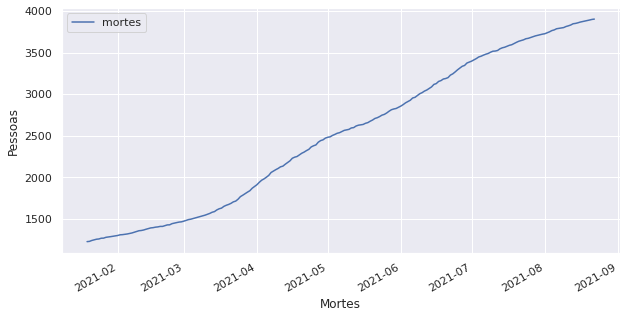

In [128]:
sns.set(rc={'figure.figsize':(10,5)})
ax = plt.gca()

tabela.plot(kind='line',x='dia',y=['mortes'],style=['-'], ax=ax)

plt.ylabel('Pessoas')
plt.xlabel('Mortes')
plt.show()

# Gráfico de casos diarios de mortes

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


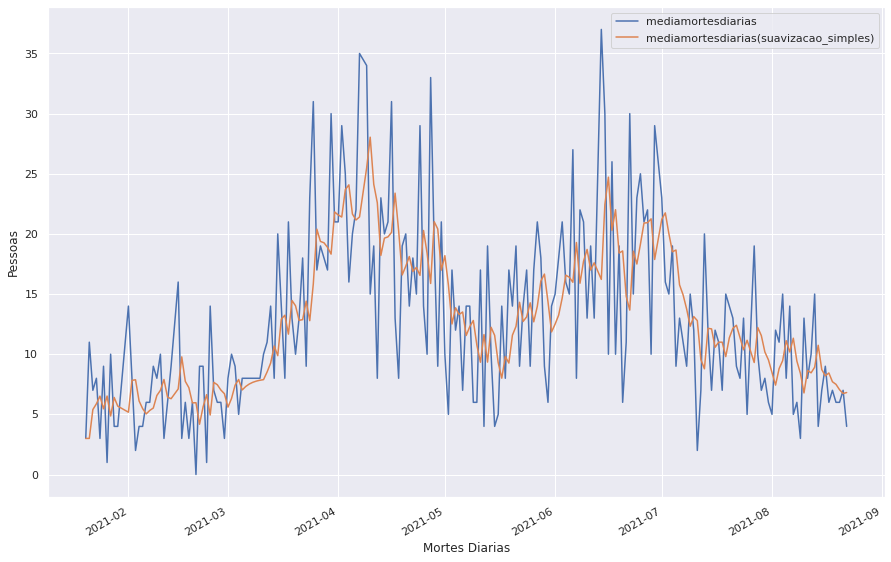

In [129]:
sns.set(rc={'figure.figsize':(15,10)})
ax = plt.gca()

tabela['mediamortesdiarias']= abs(tabela['mortes'].sub(tabela['mortes'].shift())) 


fit1 = SimpleExpSmoothing(tabela["mediamortesdiarias"].dropna()).fit(
    smoothing_level=0.3, optimized=False
)
tabela["mediamortesdiarias(suavizacao_simples)"]=pd.DataFrame(fit1.fittedvalues)

tabela.plot(kind='line',x='dia',y=['mediamortesdiarias'],style=['-'], ax=ax)
tabela.plot(kind='line',x='dia',y=['mediamortesdiarias(suavizacao_simples)'],style=['-'], ax=ax)

plt.ylabel('Pessoas')
plt.xlabel('Mortes Diarias')
plt.show()

# Gráfico de predição de diminuição de mortes em relação ao periodo da vacinação

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


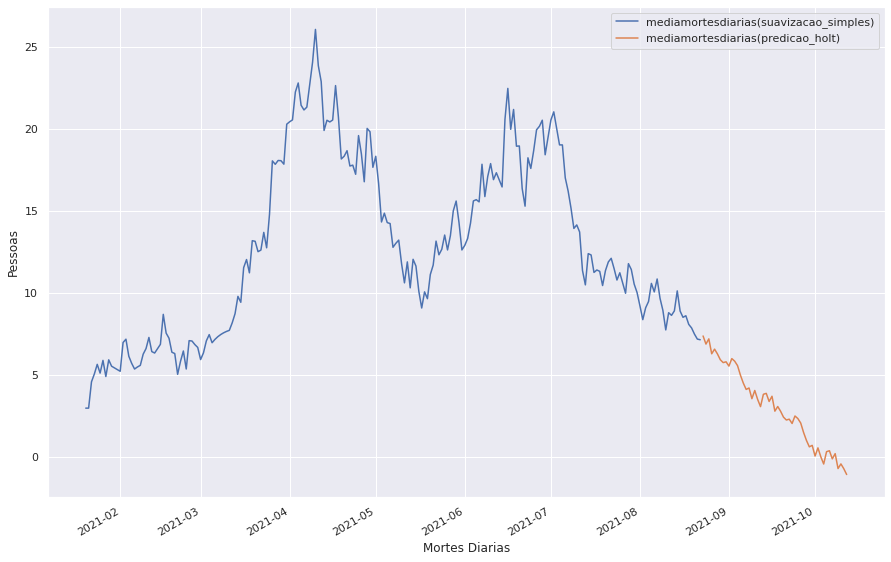

In [130]:
import copy
sns.set(rc={'figure.figsize':(15,10)})
ax = plt.gca()



table=tabela.copy()

PreverDias = 51 #@param {type:"slider", min:0, max:400, step:1}
comJanelaDe = 22 #@param {type:"slider", min:0, max:50, step:1}

table['mediamortesdiarias']= abs(table['mortes'].sub(table['mortes'].shift())) 

fit1 = SimpleExpSmoothing(table["mediamortesdiarias"].dropna()).fit(
    smoothing_level=0.2, optimized=False
)
table["mediamortesdiarias(suavizacao_simples)"]=pd.DataFrame(fit1.fittedvalues)

fit2= ExponentialSmoothing(np.asarray(table["mediamortesdiarias(suavizacao_simples)"].dropna()),
                           trend="add", seasonal="add", seasonal_periods=comJanelaDe).fit()
pred = fit2.forecast(PreverDias)


#Adicionando novos dias na tabela 
for i in range(pred.size):
   new_data = pd.DataFrame( table[-1:].values,index=[len(table.index)], columns=table.columns)
   new_data['dia']= pd.to_datetime(new_data['dia']) +pd.Timedelta("1 day")
   new_data['mediamortesdiarias(suavizacao_simples)']= float("NaN")
   table = table.append(new_data) 

#Concatenando a tabela com o valor predito  
table['mediamortesdiarias(predicao_holt)']=pd.DataFrame(pred)
table['mediamortesdiarias(predicao_holt)']=table['mediamortesdiarias(predicao_holt)'].shift(table["mediamortesdiarias(predicao_holt)"].size-PreverDias)


table.plot(kind='line',x='dia',y=['mediamortesdiarias(suavizacao_simples)'],style=['-'], ax=ax)
table.plot(kind='line',x='dia',y=['mediamortesdiarias(predicao_holt)'],style=['-'], ax=ax)


plt.ylabel('Pessoas')
plt.xlabel('Mortes Diarias')


plt.show()